# Doss-Sussman Result, Wong-Zakai Approximation & Correction Term

## 1. Doss-Sussman Result (1977)

Let $\left\{ (F_t^{(n)})_{t\geq 0} \right\}_{n=1}^\infty$ be a sequence of processes converging strongly to a Brownian motion $(W_t)_{t\geq 0}$, that is almost-surely uniformly converging on closed intervals $[0,T]$ for any $T<\infty$. In standard mathematical notation,

$$ \lim_{n\to \infty} \sup_{0\leq t\leq T} |F_t^{(n)}-W_t| = 0\quad \text{a.s.}$$

Assuming some sufficiently nice properties for the drift $\mu$ and diffusion $\sigma$, the solutions to the ODEs

$$ dX_t^{(n)} = \left(\mu(X_t^{(n)})-\frac{1}{2}\sigma'(X_t^{(n)})\sigma(X_t^{(n)})\right)\, dt + \sigma(X_t^{(n)})\, dF_t^{(n)}$$

are also converging strongly to the solution of the stochastic ODE

$$ dX_t = \mu(X_t)\, dt + \sigma(X_t)\, dW_t$$

on closed intervals $[0,T]$ for any $T<\infty$.

The correction term $\frac{1}{2}\sigma'(X_t^{(n)})\sigma(X_t^{(n)})$ here is called the Wong-Zakai term.

In [2]:
import numpy as np
from matplotlib import pyplot as plt

## 2. Initialisation: simulating Brownian motion for different time-partition

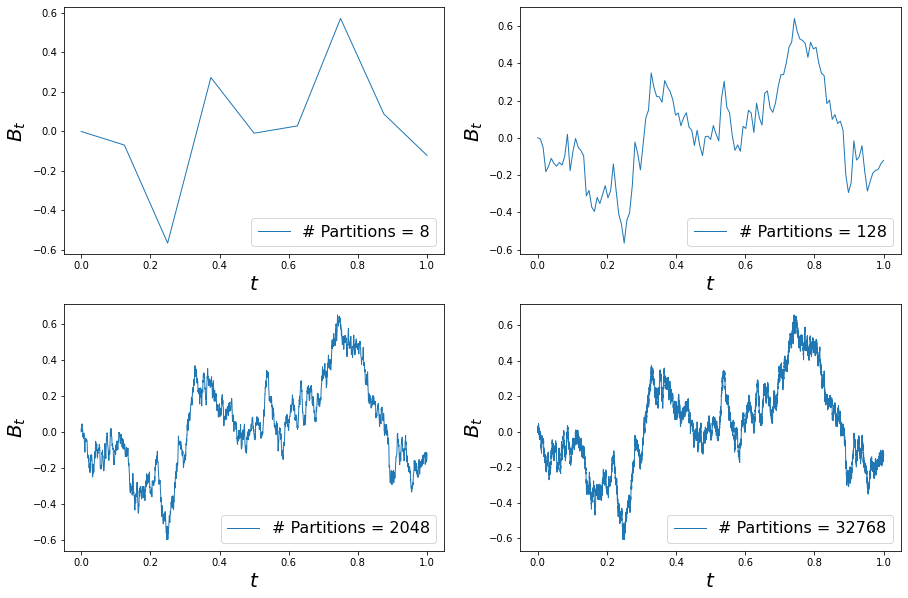

In [8]:
brown_sim = []
time_partition = []

K = 16  # max number of partitions = 2**N

# Generate iid standard normals

np.random.seed(20221228)

time = np.array([0, 1])
Z = np.array([0, np.random.normal()])

time_and_Z = np.array([time, Z])

fig, ax = plt.subplots(2,2, figsize=(15,10))
ax = ax.reshape(-1,)
i = 0

for k in range(K):
    N = 2**k+1

    midpoint = np.array([time_and_Z[:,i:i+2].mean(axis=1) for i in range(N-1)]).T

    new = np.zeros((2,2*N-1))    
    new[:,::2] = time_and_Z
    new[:,1::2] = midpoint

    # adding randomness to the interpolation
    new[1,1::2] += 2**(-0.5*k-1)*np.random.normal(size=(N-1,))

    time_and_Z = new
    
    if k+1 in [3, 7, 11, 15]:
        #plt.axis('off')
        time_partition.append(time_and_Z[0])
        brown_sim.append(time_and_Z[1])
        ax[i].plot(time_and_Z[0], time_and_Z[1],  label=f'# Partitions = {2**(k+1)}', linewidth=1)
        ax[i].set_xlabel(r'$t$', fontsize=20)
        ax[i].set_ylabel(r'$B_t$', fontsize=20)
        ax[i].legend(fontsize=16, loc='lower right')
        #ax[i].set_xticks(fontsize=15)
        #ax[i].set_yticks(fontsize=15)
        i += 1
        
ax = ax.reshape(2,2)
plt.show()

## 3. Example 1

### 3a. Without Wong-Zakai correction term

Consider the following stochastic differential equation.

$$dX_t = \left(\sqrt{1+X_t^2}+\frac{1}{2}X_t\right)\, dt + \sqrt{1+X_t^2}\, dW_t, \quad X_0=x_0\in \mathbb{R}$$

By Doss-Sussman result, we may solve this equation and obtain

$$ X_t = \sinh \left( W_t + t + \sinh^{-1}(x_0) \right)$$

First, it is natural if we try to approximate it with

$$dX_t^* = \left(\sqrt{1+\left({X}_{t}^{*}\right)^2}+\frac{1}{2}X_t^*\right)\, dt + \sqrt{1+\left({X}_{t}^{*}\right)^2} dF_t$$

where $F_t$ is a bounded-variation approximation to $W_t$ (e.g. sampled on equally-spaced time points, linearly interpolated inbetween)

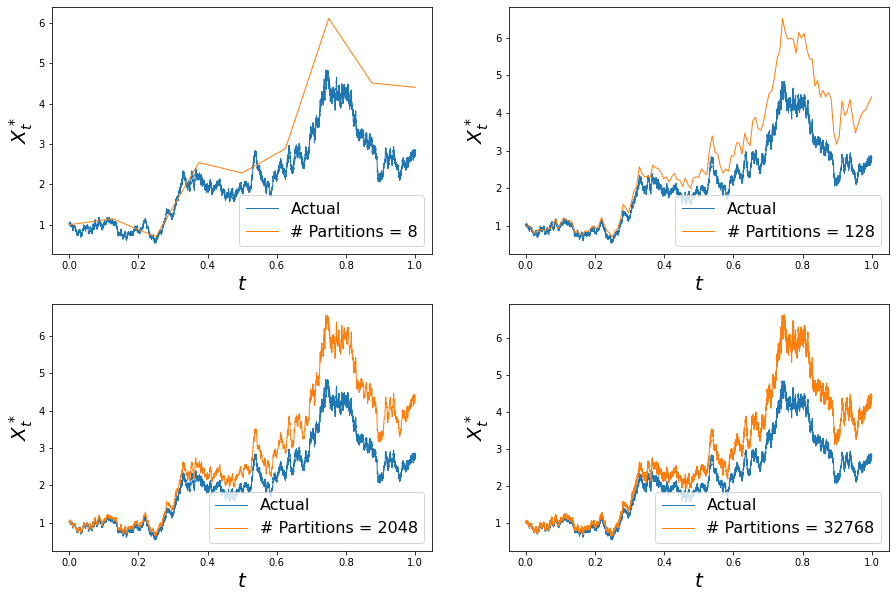

In [49]:
X0 = 1
mu = lambda t,x : np.sqrt(1+x**2) + 0.5*x
sigma = lambda t,x : np.sqrt(1+x**2)

# first compute the actual solution

W = brown_sim[-1]
t = time_partition[-1]
X_actual = np.sinh(W + t + np.arcsinh(X0))

# creating multiple plots
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax = ax.reshape(-1,)

for k in range(len(brown_sim)):
    F = brown_sim[k]
    time = time_partition[k]
    N = len(F)
    X = np.zeros(N,)
    X[0] = X0
    dt = 1/(N-1)
    
    # To compute X(t_{i}) from X(t_{i-1}), we need to:
    # 1. partition the subintervals
    # 2. carry out Euler's Method for ODE on the new, more refined partition 
    # (remember that the approximation Ft is differentiable a.e.)
    
    for i in range(1,N):
        # initialize a smoother partition of the partition
        M = 100
        t_start = t[i-1]
        dt_small = dt/M
        F_start, F_end = F[i-1], F[i]
        dFt = (F_end - F_start)/M
        
        # initial condition for Euler's Method
        X_start = X[i-1]
            
        for j in range(1,M+1):
            dX = mu(t_start, X_start)*dt_small + sigma(t_start, X_start)*dFt
            X_start += dX
            t_start += dt_small
            
        # X(t_i) is successfully computed
        X[i] = X_start
     
    ax[k].plot(t, X_actual,  label=f'Actual', linewidth=1) 
    ax[k].plot(time, X,  label=f'# Partitions = {N-1}', linewidth=1)   
    ax[k].set_xlabel(r'$t$', fontsize=20)
    ax[k].set_ylabel(r'$X_t^*$', fontsize=20)
    ax[k].legend(fontsize=16, loc='lower right')
    
ax = ax.reshape(2,2)
plt.show()

It turns out that the approximation overestimated the actual solution.

### 3b. With Wong-Zakai correction term

Now, let's try another approximation

$$dX_t^* = \sqrt{1+\left({X}_{t}^{*}\right)^2}\, dt + \sqrt{1+\left({X}_{t}^{*}\right)^2} dF_t$$

From the drift term, we've subtracted the term $\frac{1}{2}X_t^*\, dt$ which exactly equals $\frac{1}{2}\sigma(X_t)\sigma'(X_t)\, dt$ where $\sigma$ is the diffusion term $\sigma(X_t)=\sqrt{1+\left({X}_{t}^{*}\right)^2}$. This term is called the Wong-Zakai correction term.

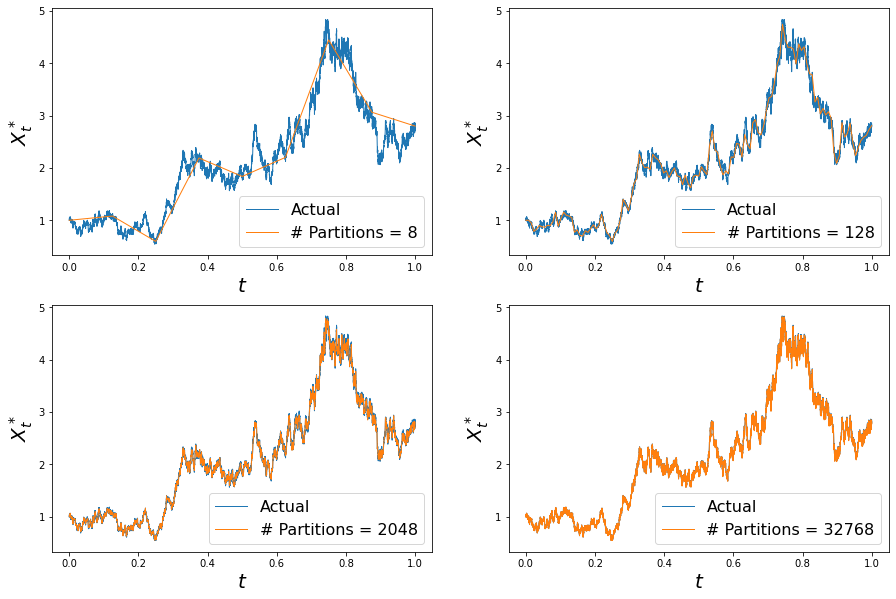

In [50]:
X0 = 1
mu = lambda t,x : np.sqrt(1+x**2)
sigma = lambda t,x : np.sqrt(1+x**2)

# first compute the actual solution

W = brown_sim[-1]
t = time_partition[-1]
X_actual = np.sinh(W + t + np.arcsinh(X0))

# creating multiple plots
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax = ax.reshape(-1,)

for k in range(len(brown_sim)):
    F = brown_sim[k]
    time = time_partition[k]
    N = len(F)
    X = np.zeros(N,)
    X[0] = X0
    dt = 1/(N-1)
    
    # To compute X(t_{i}) from X(t_{i-1}), we need to:
    # 1. partition the subintervals
    # 2. carry out Euler's Method for ODE on the new, more refined partition 
    # (remember that the approximation Ft is differentiable a.e.)
    
    for i in range(1,N):
        # initialize a smoother partition of the partition
        M = 100
        t_start = t[i-1]
        dt_small = dt/M
        F_start, F_end = F[i-1], F[i]
        dFt = (F_end - F_start)/M
        
        # initial condition for Euler's Method
        X_start = X[i-1]
            
        for j in range(1,M+1):
            dX = mu(t_start, X_start)*dt_small + sigma(t_start, X_start)*dFt
            X_start += dX
            t_start += dt_small
            
        # X(t_i) is successfully computed
        X[i] = X_start
    
    ax[k].plot(t, X_actual,  label=f'Actual', linewidth=1) 
    ax[k].plot(time, X,  label=f'# Partitions = {N-1}', linewidth=1)   
    ax[k].set_xlabel(r'$t$', fontsize=20)
    ax[k].set_ylabel(r'$X_t^*$', fontsize=20)
    ax[k].legend(fontsize=16, loc='lower right')
    
ax = ax.reshape(2,2)
plt.show()

As seen above, this new approximation is better.

## 4. Example 2: Geometric Brownian Motion

### 4a. Without Wong-Zakai correction term

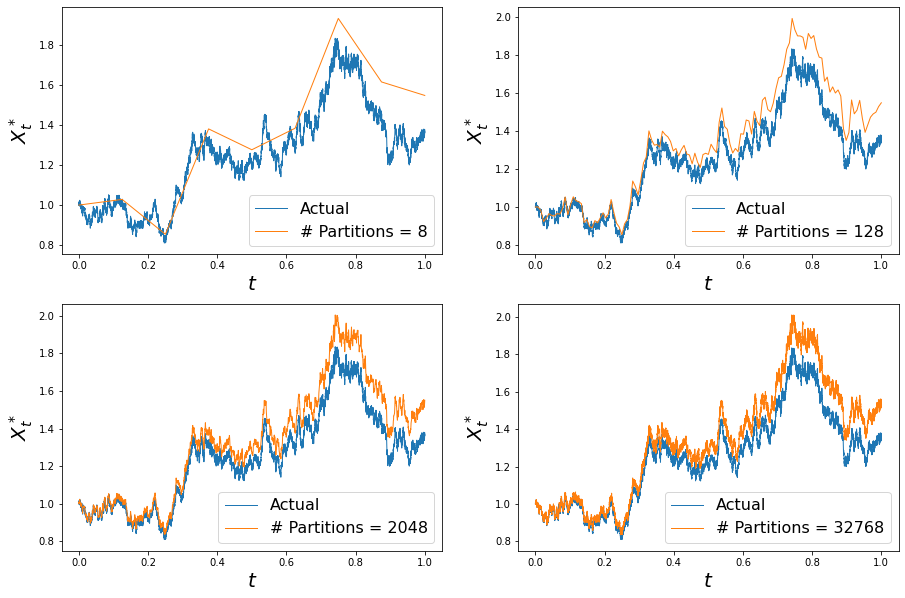

In [51]:
X0 = 1
mu_const = 0.5
sigma_const = 0.5
mu = lambda t,x : mu_const*x  # without Wong-Zakai correction
sigma = lambda t,x : sigma_const*x

# first compute the actual solution

W = brown_sim[-1]
t = time_partition[-1]
X_actual = np.exp((mu_const-0.5*sigma_const**2)*t + sigma_const*W)

# creating multiple plots
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax = ax.reshape(-1,)

for k in range(len(brown_sim)):
    F = brown_sim[k]
    time = time_partition[k]
    N = len(F)
    X = np.zeros(N,)
    X[0] = X0
    dt = 1/(N-1)
    
    # To compute X(t_{i}) from X(t_{i-1}), we need to:
    # 1. partition the subintervals
    # 2. carry out Euler's Method for ODE on the new, more refined partition 
    # (remember that the approximation Ft is differentiable a.e.)
    
    for i in range(1,N):
        # initialize a smoother partition of the partition
        M = 100
        t_start = t[i-1]
        dt_small = dt/M
        F_start, F_end = F[i-1], F[i]
        dFt = (F_end - F_start)/M
        
        # initial condition for Euler's Method
        X_start = X[i-1]
            
        for j in range(1,M+1):
            dX = mu(t_start, X_start)*dt_small + sigma(t_start, X_start)*dFt
            X_start += dX
            t_start += dt_small
            
        # X(t_i) is successfully computed
        X[i] = X_start
     
    ax[k].plot(t, X_actual,  label=f'Actual', linewidth=1) 
    ax[k].plot(time, X,  label=f'# Partitions = {N-1}', linewidth=1) 
    ax[k].set_xlabel(r'$t$', fontsize=20)
    ax[k].set_ylabel(r'$X_t^*$', fontsize=20)
    ax[k].legend(fontsize=16, loc='lower right')
    
ax = ax.reshape(2,2)
plt.show()    

The uncorrected approximation also overestimated the actual solution.

### With Wong-Zakai correction term

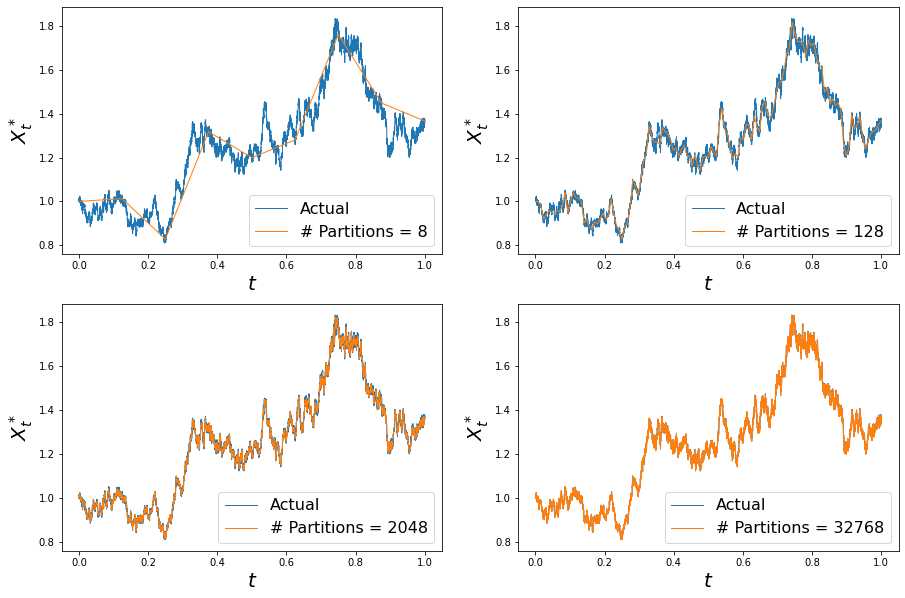

In [52]:
X0 = 1
mu_const = 0.5
sigma_const = 0.5
mu = lambda t,x : mu_const*x - 0.5*(sigma_const**2)*x # without Wong-Zakai correction
sigma = lambda t,x : sigma_const*x

# first compute the actual solution

W = brown_sim[-1]
t = time_partition[-1]
X_actual = np.exp((mu_const-0.5*sigma_const**2)*t + sigma_const*W)

# creating multiple plots
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax = ax.reshape(-1,)

for k in range(len(brown_sim)):
    F = brown_sim[k]
    time = time_partition[k]
    N = len(F)
    X = np.zeros(N,)
    X[0] = X0
    dt = 1/(N-1)
    
    # To compute X(t_{i}) from X(t_{i-1}), we need to:
    # 1. partition the subintervals
    # 2. carry out Euler's Method for ODE on the new, more refined partition 
    # (remember that the approximation Ft is differentiable a.e.)
    
    for i in range(1,N):
        # initialize a smoother partition of the partition
        M = 100
        t_start = t[i-1]
        dt_small = dt/M
        F_start, F_end = F[i-1], F[i]
        dFt = (F_end - F_start)/M
        
        # initial condition for Euler's Method
        X_start = X[i-1]
            
        for j in range(1,M+1):
            dX = mu(t_start, X_start)*dt_small + sigma(t_start, X_start)*dFt
            X_start += dX
            t_start += dt_small
            
        # X(t_i) is successfully computed
        X[i] = X_start
        
    ax[k].plot(t, X_actual,  label=f'Actual', linewidth=1) 
    ax[k].plot(time, X,  label=f'# Partitions = {N-1}', linewidth=1)
    ax[k].set_xlabel(r'$t$', fontsize=20)
    ax[k].set_ylabel(r'$X_t^*$', fontsize=20)
    ax[k].legend(fontsize=16, loc='lower right')
    
ax = ax.reshape(2,2)
plt.show()

Now the corrected approximation estimated the actual solution better.